# Import data directly from Kaggle to Google Colab

In [ ]:
#pip install kaggle

In [ ]:
import pandas as pd
from google.colab import files

In [ ]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"igorradovanovic","key":"b7b1cfee49cdd2c113927328a323457b"}'}

In [ ]:
ls -lha kaggle.json

-rw-r--r-- 1 root root 71 Apr 10 18:23 kaggle.json


In [ ]:
# The Kaggle API client expects this file to be in ~/.kaggle,
# and we will move it there
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d camnugent/california-housing-prices

  0% 0.00/400k [00:00<?, ?B/s]
100% 400k/400k [00:00<00:00, 59.8MB/s]


In [ ]:
# Unzip the data and delete the zip
!unzip california-housing-prices.zip  && rm california-housing-prices.zip

Archive:  california-housing-prices.zip
  inflating: housing.csv             


In [ ]:
df = pd.read_csv('/content/housing.csv')
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


# EDA

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [ ]:
df['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [ ]:
df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

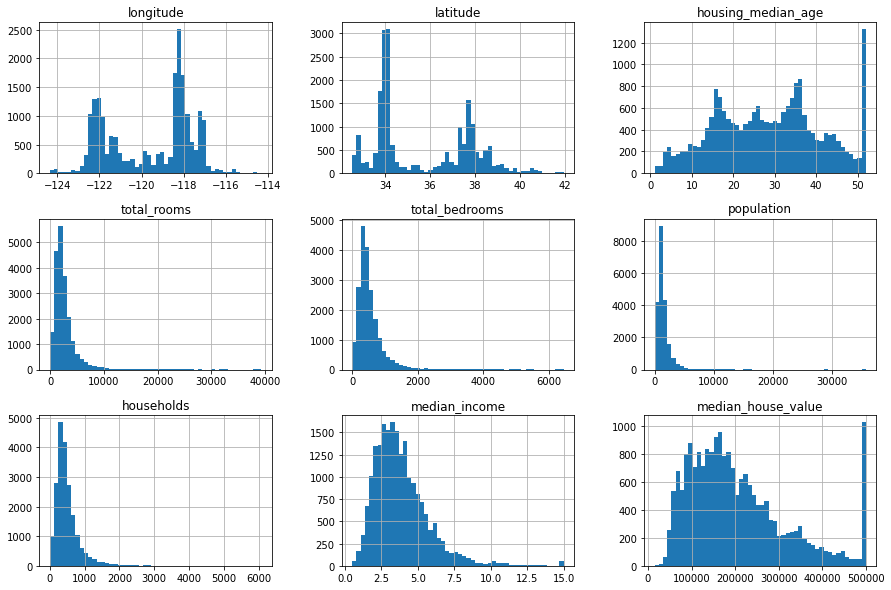

In [ ]:
df.hist(bins=50, figsize=(15,10))
plt.show()

## Split the data into train and test sets to avoid the "Data Snooping Bias"

In [ ]:
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit

In [ ]:
# As we want the stratums of data income to be representative we will split the data by them
# But first, we need to create these stratums
df['income_stratums'] = pd.cut(df['median_income'],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

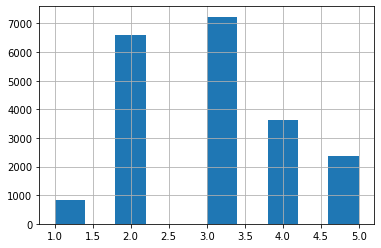

In [ ]:
df['income_stratums'].hist()

In [ ]:
# Split the data by stratums
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(df, df['income_stratums']):
  train_set = df.loc[train_index]
  test_set = df.loc[test_index]

# Delete the income_stratums column
for stratum in (train_set, test_set):
  stratum.drop('income_stratums', axis=1, inplace=True)

## Graph the housing prices

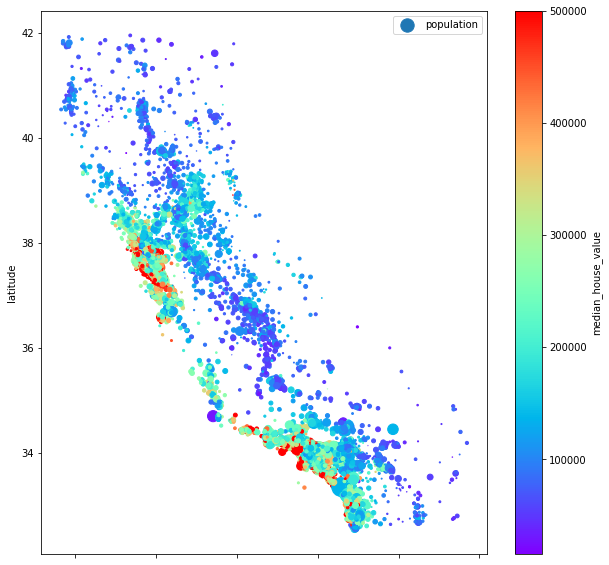

In [ ]:
train_set.plot(kind='scatter', x='longitude', y='latitude', figsize=(10,10),
               s=train_set['population']/100, label='population',
               c='median_house_value', cmap='rainbow',
               colorbar=True)
plt.legend()

## Variable correlations

In [ ]:
# Before looking at correlations we might want to create new features that make more sense
# Let's look at the variables that we have
test_set

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
5241,-118.39,34.12,29.0,6447.0,1012.0,2184.0,960.0,8.2816,500001.0,<1H OCEAN
10970,-117.86,33.77,39.0,4159.0,655.0,1669.0,651.0,4.6111,240300.0,<1H OCEAN
20351,-119.05,34.21,27.0,4357.0,926.0,2110.0,876.0,3.0119,218200.0,<1H OCEAN
6568,-118.15,34.20,52.0,1786.0,306.0,1018.0,322.0,4.1518,182100.0,INLAND
13285,-117.68,34.07,32.0,1775.0,314.0,1067.0,302.0,4.0375,121300.0,INLAND
...,...,...,...,...,...,...,...,...,...,...
20519,-121.53,38.58,33.0,4988.0,1169.0,2414.0,1075.0,1.9728,76400.0,INLAND
17430,-120.44,34.65,30.0,2265.0,512.0,1402.0,471.0,1.9750,134000.0,NEAR OCEAN
4019,-118.49,34.18,31.0,3073.0,674.0,1486.0,684.0,4.8984,311700.0,<1H OCEAN
12107,-117.32,33.99,27.0,5464.0,850.0,2400.0,836.0,4.7110,133500.0,INLAND


In [ ]:
# Create new features
df['bedrooms_per_room'] = df['total_bedrooms']/df['total_rooms']
df['population_per_household'] = df['population']/df['households']
df['rooms_per_household'] = df['total_rooms']/df['households']

In [ ]:
# Check for correlations
correlations = df.corr()
correlations['median_house_value'].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.688075
rooms_per_household         0.151948
total_rooms                 0.134153
housing_median_age          0.105623
households                  0.065843
total_bedrooms              0.049686
population_per_household   -0.023737
population                 -0.024650
longitude                  -0.045967
latitude                   -0.144160
bedrooms_per_room          -0.255880
Name: median_house_value, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9779c93610>,
      dtype=object)

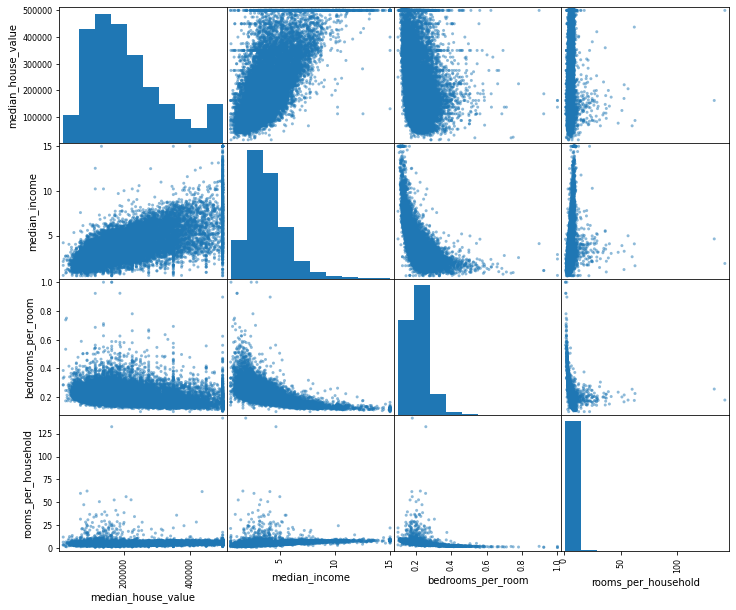

In [ ]:
variables =['median_house_value', 'median_income',
            'bedrooms_per_room', 'rooms_per_household']
pd.plotting.scatter_matrix(df[variables], figsize=(12, 10))

# Machine Learning

## Data Preprocessing

In [ ]:
#pip install missingno
import missingno

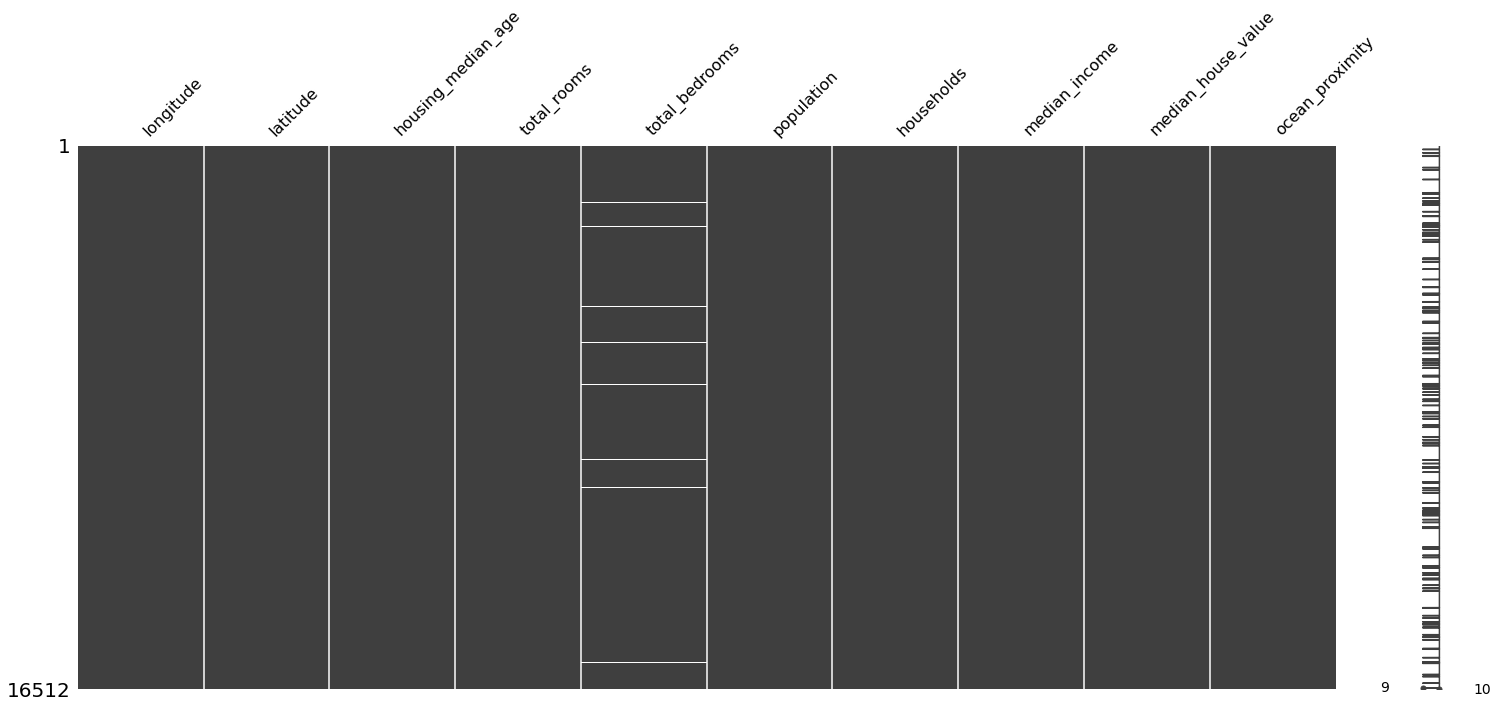

In [ ]:
# Do we have missing data?
missingno.matrix(train_set)

In [ ]:
# Split Train Set
housing_features = train_set.drop('median_house_value', axis=1)
housing_label = train_set['median_house_value'].copy()

In [ ]:
# Split housing_features to categorical and numerical sets
numerical = housing_features.drop('ocean_proximity', axis=1)
categorical = housing_features['ocean_proximity'].copy()

Create an sklearn numerical pipeline that:
* Imputes missing data by the median value
* Creates new features 
* Standardizes the numerical features

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# Create a function that creates new features (Inspired by Aurelien Geron)
rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6
class FeatureGenerator(BaseEstimator, TransformerMixin):
  def __init__(self, add_bedrooms_per_room=True):
    self.add_bedrooms_per_room = add_bedrooms_per_room
  def fit(self, X, y=None):
    return self
  def transform(self, X, y=None):
    rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
    population_per_household = X[:, population_ix] / X[:, households_ix]
    if self.add_bedrooms_per_room:
      bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
      return np.c_[X, rooms_per_household, population_per_household, 
                   bedrooms_per_room]
    else:
      return np.c_[X, rooms_per_household, population_per_household]

# Numerical pipeline
numerical_pipe = Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('feature_generator', FeatureGenerator()),
            ('standardizer', StandardScaler()),
            ])

Create a categorial pipeline:
* That performs One Hot Encoding

Merge the two pipelines for full preprocessing

In [ ]:
numerical_features = list(numerical)
categorical_features = ["ocean_proximity"]
categorical_features

['ocean_proximity']

In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

# Create a complete preprocessing pipeline
num_features = list(numerical)
cat_features = ["ocean_proximity"]

complete_pipeline = ColumnTransformer([
        ("num", numerical_pipe, num_features),
        ("cat", OneHotEncoder(), cat_features),
    ])

# Run all features through the pipeline
housing = complete_pipeline.fit_transform(housing_features)
housing.shape

(16512, 16)

## Pick a model and evaluate it

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

clf = RandomForestRegressor(random_state=42)
clf.fit(housing, housing_label)
housing_predictions = clf.predict(housing)
mse = mean_squared_error(housing_label, housing_predictions)
rmse = np.sqrt(mse)
rmse

18603.515021376355

## Optimize the model

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

hyperparameters = {
        'n_estimators': randint(low=1, high=250),
        'max_features': randint(low=1, high=10),
    }

rnd_search = RandomizedSearchCV(clf, param_distributions=hyperparameters,
                                n_iter=15, cv=5, scoring='neg_mean_squared_error', random_state=42)
rnd_search.fit(housing, housing_label)

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                              

In [ ]:
cv = rnd_search.cv_results_
for mean_score, params in zip(cv["mean_test_score"], cv["params"]):
    print(np.sqrt(-mean_score), params)

49150.70756927707 {'max_features': 7, 'n_estimators': 180}
49054.37299110557 {'max_features': 8, 'n_estimators': 189}
49578.387794914874 {'max_features': 5, 'n_estimators': 103}
50328.46972664108 {'max_features': 3, 'n_estimators': 215}
49141.3858465869 {'max_features': 8, 'n_estimators': 117}
49616.452650033905 {'max_features': 4, 'n_estimators': 104}
49133.58820893898 {'max_features': 8, 'n_estimators': 131}
49644.96067825461 {'max_features': 6, 'n_estimators': 53}
52002.53259317271 {'max_features': 2, 'n_estimators': 88}
49330.86513175718 {'max_features': 6, 'n_estimators': 130}
49357.136695989066 {'max_features': 5, 'n_estimators': 161}
49177.80243290564 {'max_features': 6, 'n_estimators': 236}
49785.40318660812 {'max_features': 9, 'n_estimators': 49}
50653.19190823839 {'max_features': 3, 'n_estimators': 108}
49071.0208961133 {'max_features': 7, 'n_estimators': 244}


In [ ]:
model = RandomForestRegressor(n_estimators=189, max_features=8, random_state=42)

X_test = test_set.drop("median_house_value", axis=1)
y_test = test_set["median_house_value"].copy()

X_test = full_pipeline.transform(X_test)
model.fit(housing, housing_label)
predictions = model.predict(X_test)

mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
rmse

46879.445567883995